# <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2; text-align: center;">Preprocessing</div>

Dataset description:

 To tackle fake news, in this paper, we present a dataset of social media posts and articles on COVID-19 with real and fake labels. The targeted media platforms for the data collection are designated to be the ones that are actively used for social networking for peer communication and relaying information, which could be in the form
 of news, events, social phenomenon, etc. We collect both real news and fake claims that surfaced on social media on COVID-19 topic. Fake claims are collected from various fact-checking websites like Politifact, NewsChecker, Boomlive, etc., and from tools like Google fact-check-explorer and IFCN chatbot. Real news is collected from
 Twitter using verified twitter handles. We also perform exploratory data analysis and implement four machine learning baselines.

Information source per label:
* Real- Tweets from verified sources.
* Fake- Tweets, posts, articles.


Source: [Fighting an Infodemic: COVID-19 Fake News Dataset](https://arxiv.org/pdf/2011.03327)

## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Load data</div>

In [136]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import html

In [137]:
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

In [138]:
DATA = 'data/'
test = pd.read_csv(DATA + 'Constraint_English_Test.csv', delimiter=';', encoding='utf-8')
train = pd.read_csv(DATA + 'Constraint_English_Train.csv', delimiter=';', encoding='utf-8')
val = pd.read_csv(DATA + 'Constraint_English_Val.csv', delimiter=';', encoding='utf-8')

In [139]:
tweets = pd.concat([train, val, test], ignore_index=True)
tweets.drop(columns=['id'], inplace=True)
tweets['tweet'] = tweets['tweet'].apply(html.unescape)

It is necessary to transform the text from html, because previously there were some html symbols like &amp, that were not transformed into the correct character and could affect the text analysis.

In [140]:
tweets.head()

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real
2,Politically Correct Woman (Almost) Uses Pandem...,fake
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,Populous states can generate large case counts...,real


## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Exploratory Data Analysis (EDA)</div>

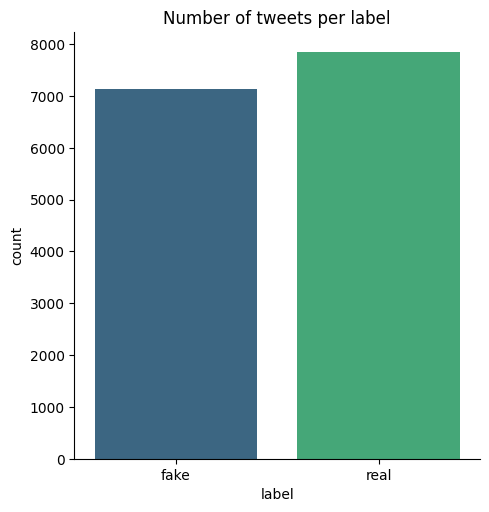

In [161]:
p = sns.catplot(x='label', hue='label', kind='count', data=tweets, palette='viridis')
p.set(title='Number of tweets per label')

In [142]:
tweets = tweets.astype({"tweet": "string", "label":"category"})

In [143]:
tweets.describe()

,tweet,label
count,14980,14980
unique,8559,2
top,Our combined total of confirmed and probable c...,real
freq,3,7840


In [144]:
# Search for duplicate reviews
tweets[tweets['tweet'].isin(tweets['tweet'][tweets['tweet'].duplicated()])]

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real
2,Politically Correct Woman (Almost) Uses Pandem...,fake
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,Populous states can generate large case counts...,real
...,...,...
14975,A tiger tested positive for COVID-19 please st...,fake
14976,???Autopsies prove that COVID-19 is??� a blood...,fake
14977,_A post claims a COVID-19 vaccine has already ...,fake
14978,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake


### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">Message length</div>

A simple analysis of the length of the messages can be useful to understand the distribution of the data. We'll make a copy of the dataset so the original one is not modified.

The message will be analyzed by the number of characters and words to check if there is any difference between the real and fake tweets.

In [145]:
tweets_analisis = tweets.copy()
tweets_analisis['length'] = tweets_analisis['tweet'].str.len()

In [146]:
# define functions to analyze the text
def word_count(tweet):
    "Split text in words and count them"
    tweet_list = tweet.split()
    return len(tweet_list)

def mean_word_length(tweet):
    "Split text in words and calculate the mean length"
    return np.mean([len(word) for word in tweet.split()])

def count_words_in_set(tweet, word_set):
    "Count the number of words in a set"
    return len([word for word in tweet.split() if word in word_set])


In [147]:
# count words
tweets_analisis['word_count'] = tweets_analisis['tweet'].apply(word_count)

In [148]:
# mean word length
tweets_analisis['mean_word_length'] = tweets_analisis['tweet'].apply(mean_word_length)

In [149]:
# peek at the data
tweets_analisis.head()

,tweet,label,length,word_count,mean_word_length
0,The CDC currently reports 99031 deaths. In gen...,real,190,29,5.586207
1,States reported 1121 deaths a small rise from ...,real,129,18,6.222222
2,Politically Correct Woman (Almost) Uses Pandem...,fake,131,16,7.250000
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real,204,27,6.592593
4,Populous states can generate large case counts...,real,231,42,4.523810


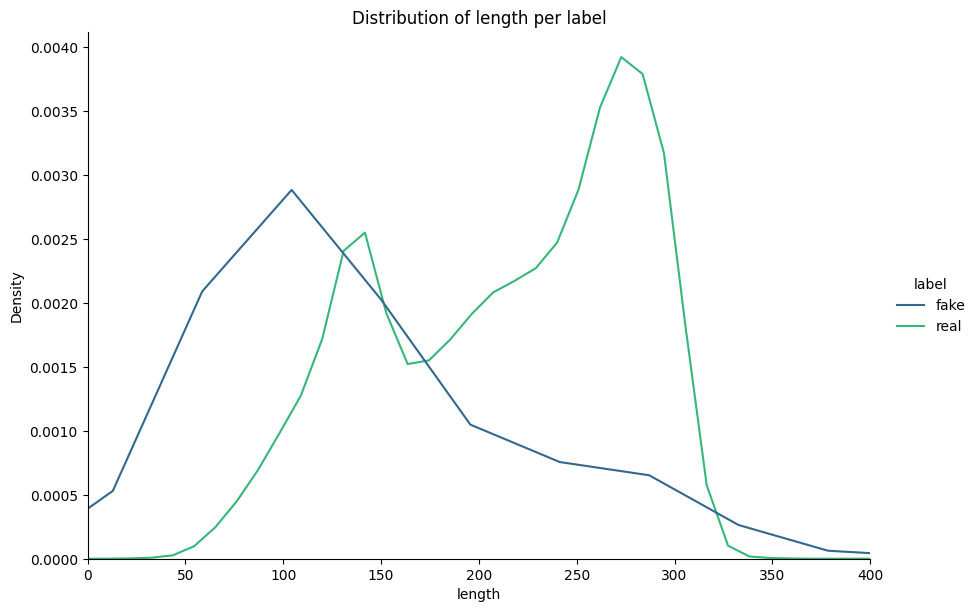

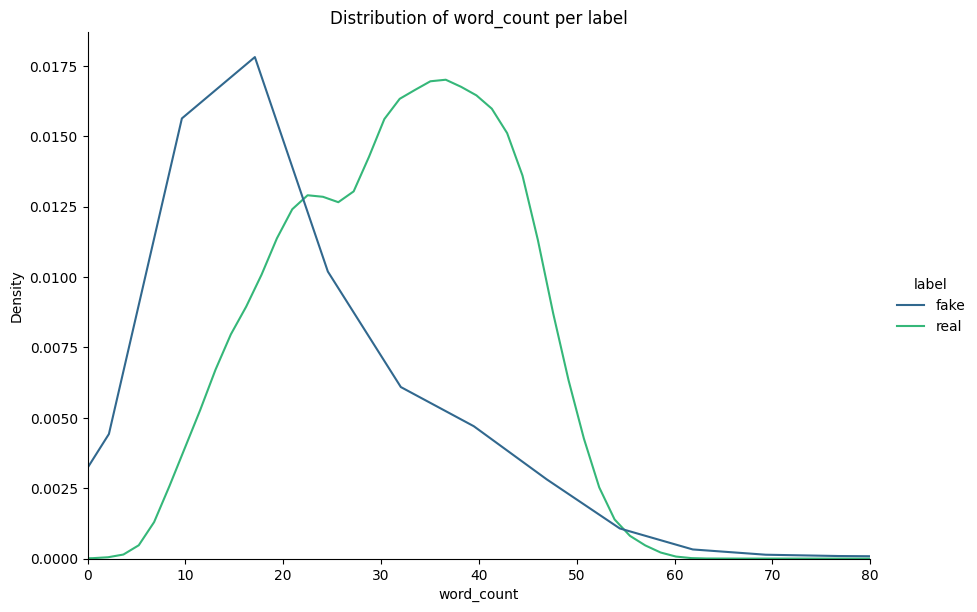

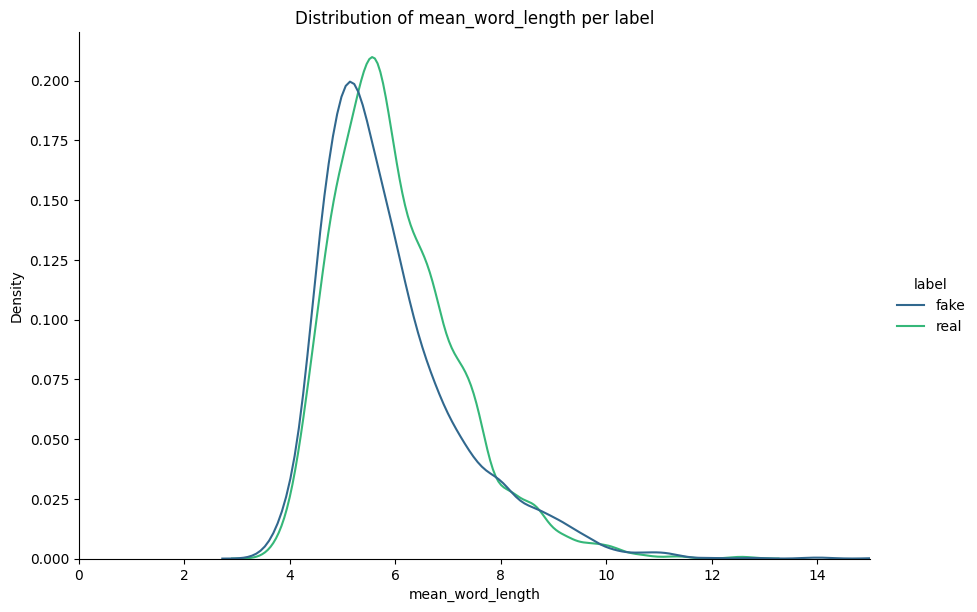

In [150]:
show_limited = True # whether to cut the x-axis or not, true for a clearer visualization
features = tweets_analisis.columns.tolist()[2:]
features_limits = [(features[0], 400), (features[1], 80), (features[2], 15)]

for feature, x_limit in features_limits:
    p = sns.displot(tweets_analisis, x=feature, hue='label', palette='viridis', height=6, aspect=1.5, kind='kde')
    if show_limited:
        p.set(title=f'Distribution of {feature} per label', xlim=(0, x_limit))
    else:
        p.set(title=f'Distribution of {feature} per label')

Taking a look at the plots above, we can extract some insights:
* Regarding the number of characters, fake messages tent to have less than 200 while real messages have its peak around 300 characters, although there's another peak at 150.
* The number of words is also higher in real messages.
* The mean length of a word is slightly higher in real messages.

Therefore, we can extract that real messages contain more information than fake messages, with a better structred text or include more links, hashtags, etc. We have to take into account that text hasn't been preprocessed yet, so it includes all the characters and links.

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">Word Cloud</div>

With the word cloud, we can have a quick look at the most common words in the dataset. We'll create a word cloud for both real and fake messages. In this case, we'll take into account the stopwords and other words that don't provide much information as links.

Stopwords are common words that don't provide much information. For example, in English, words like "the", "is", "and", etc. are stopwords. We'll remove them from the text to avoid them in the word cloud.

In [151]:
# import package
from wordcloud import WordCloud

In [152]:
# group messages by label
real_messages = (" ").join(tweets["tweet"][tweets['label'] == 'real'])
fake_messages = (" ").join(tweets["tweet"][tweets['label'] == 'fake'])

In [153]:
# we'll have to deal with stopwords and other useless words or links later
stopwords_wordcloud = set(stopwords.words('english'))
stopwords_wordcloud.update(['https', 'co', 't'])

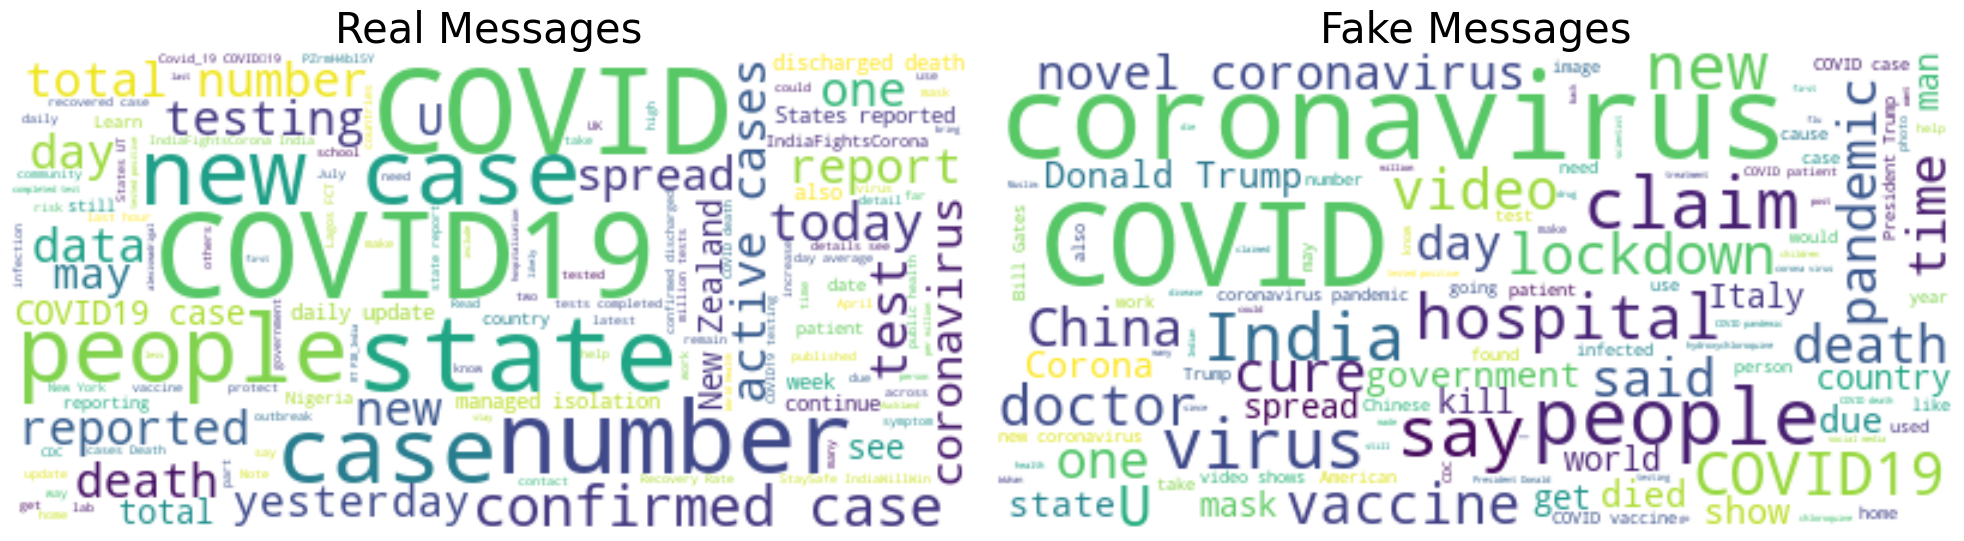

In [154]:
plt.figure(figsize=(20, 10)) 
messages = [real_messages, fake_messages]
titles = ["Real Messages", "Fake Messages"]

for idx, text in enumerate(messages):
    plt.subplot(1, 2, idx + 1)
    # set max_font_size to get more words
    wordcloud = WordCloud(background_color='white', max_font_size=50, random_state=42, 
                          stopwords=stopwords_wordcloud).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(titles[idx], fontsize=30)  

plt.subplots_adjust(wspace=0.3) 
plt.tight_layout(pad=2.0)      
plt.show()

Most relevant words in the dataset:

Real messages: "case", "confirmed", "data", "report", "testing", "people", "daily update", "total".

Fake messages: "claim", "virus", "time", "say", "die", "pandemic", "lockdown", "Donald Trump", "government", "video", "kill", "China".

No relevant information can be extracted from the wordclouds, however, we can see that real messages contain words with intent to inform, while fake messages contain more variety of words.

In theory, real messages are more structured, longer and contain more information, so they will have a higher number of stopwords. Let's check if this is true.

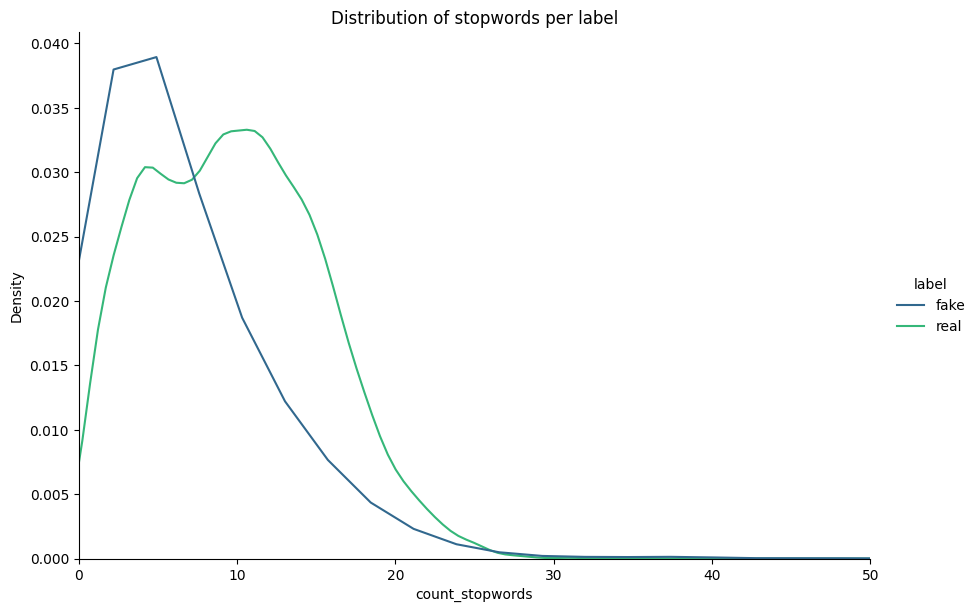

In [155]:
tweets_analisis['count_stopwords'] = tweets_analisis['tweet'].apply(lambda x: count_words_in_set(x, stopwords_wordcloud))
p = sns.displot(tweets_analisis, x="count_stopwords", hue='label', palette='viridis', height=6, aspect=1.5, kind='kde')
p.set(title='Distribution of stopwords per label', xlim=(0, 50))

As we are working with texts from the social media, it's also interesting to check the number of links and hastags attached to the messages.

In [166]:
def count_links(tweet):
    "Count the number of links in a tweet"
    return len([word for word in tweet.split() if 'http' in word])

def count_hashtags(tweet):
    "Count the number of hashtags in a tweet"
    return len([word for word in tweet.split() if '#' in word])

In [157]:
tweets_analisis['count_links'] = tweets_analisis['tweet'].apply(count_links)
tweets_analisis['count_links'].groupby(tweets_analisis['label'], observed=True).value_counts(sort=False)

label  count_links
fake   0              4812
       1              1730
       2               596
       3                 2
real   0              2399
       1              3566
       2              1847
       3                13
       4                14
       14                1
Name: count, dtype: int64

Usually, fake messages doesn't have any link and while a higher number of real messages contain at least one link.

In [158]:
tweets_analisis[tweets_analisis['count_links']==14]['tweet'].values

<StringArray>
['I\'m so happy that we’re able to do something very concrete that will help people” says Cynthia Ogden who leads a team at the National Health and Nutrition Examination Survey. The team turned their lab vehicles into mobile #COVID19 testing sites: https://t.co/JDbd7PMZ4z. https://t.co/B1pBH5j6ul\r\nA statewide survey of Indiana residents in late April estimated that #COVID19 infections were 10 times that of reported cases which is in line with previous antibody studies. Learn more in @CDCMMWR: https://t.co/wsN4MvDIKk. https://t.co/4bcpBPulRN\r\nLate April/early May antibody tests from some Atlanta households showed most residents had not been infected with #COVID19. Black residents had higher rates of past infection highlighting the need to address racial & ethnic health inequities. Learn more: https://t.co/LXO2LpafJq. https://t.co/liNvsdrkQ8\r\nParents: Help your grad stay healthy no matter where life takes them. Whether it’s finding a doctor scheduling checkups filling

A message with 14 links is clearly an outlier but it looks like an interview or a report. We'll keep it for now.

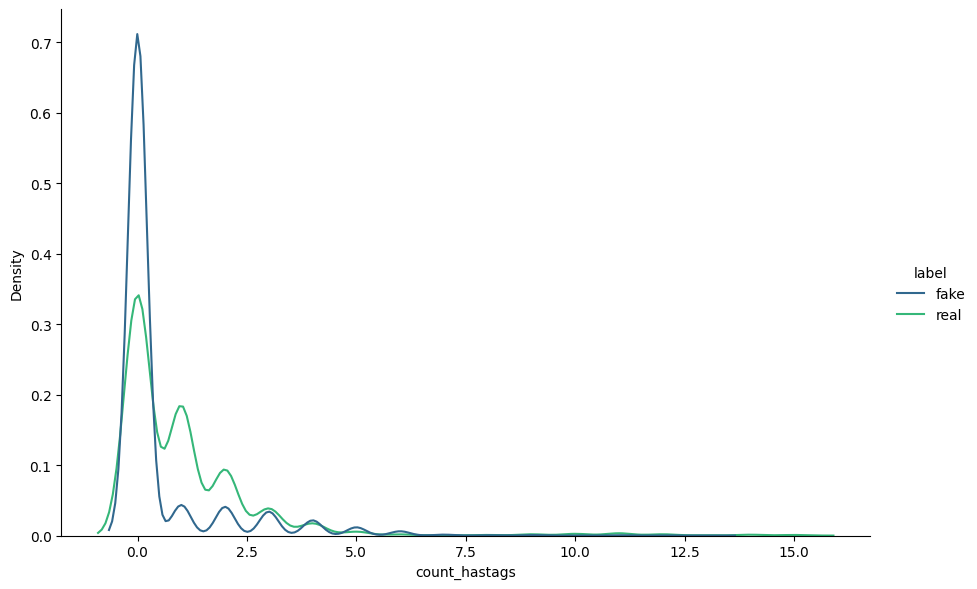

In [168]:
tweets_analisis['count_hastags'] = tweets_analisis['tweet'].apply(count_hashtags)
sns.displot(tweets_analisis, x='count_hastags', hue='label', palette='viridis', height=6, aspect=1.5, kind='kde')

In general, real messages contain more links and hashtags than fake messages. However, this information might be affected by the data source, as real messages are only taken from Twitter.

## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Preprocessing</div>